## **SHapley Additive exPlanations** 

**SHAP** is an approach to explain the output of any machine learning model. 

It utilizes a **game-theoretic** perspective.

Connection between game-theoretic and ML prediction interpretability:

- Game: prediction task
- Gain: actual prediction - average prediction for all instances
- Players: feature values that collaborate to receive the gan

**Key advantages of SHAP:**

* **Model-agnostic:** Applicable to any machine learning model, regardless of its complexity.
* **Feature importance:** Provides a clear understanding of which features are most influential in the model's predictions.
* **Local and global explanations:** Can provide both individual predictions and global insights into the model's behavior.


In [5]:
import sklearn
import pandas as pd
import shap
import xgboost

shap.initjs()

In [6]:
X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

## **Understanding Feature Importance: Beyond Coefficient Magnitude**

Most common way of understanding a linear model is to eamine the coefficients associated to each feature. These coefficients tell us how much the model output changes when we change each of the input features.
Coefficients are great for telling us what will happen when we change the value of a input feature but they are not a great way to measure the overall importance of a feature.
This is because the value of each coefficient depends on the scale of the input features.
If for example we were to measure the age of a home in minutes instead of years, then the coefficients for the HouseAge feature would become bigger.

In [7]:
print('Linear Regression Coefficient')
pd.DataFrame(zip(model.feature_names_in_,model.coef_), columns=['Feature','Coefficient']).sort_values(by = 'Coefficient', ascending=False)

Linear Regression Coefficient


,Feature,Coefficient
3,AveBedrms,0.663848
0,MedInc,0.425630
1,HouseAge,0.010335
4,Population,0.000032
2,AveRooms,-0.116096
5,AveOccup,-0.260959
7,Longitude,-0.462716
6,Latitude,-0.467338


In [8]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

NameError: name 'shap_values' is not defined

**The Right Approach: Impact on Model Output**

Two key question:
- How changing that feature impacts the model's output
- Distribution of that feature's values

To visualize this for a linear model we can build **Partial Dependence Plot (PDP)**

**Interpreting PDPs**

* **Gray Horizontal Line:** Represents the average prediction of the model across the entire dataset.
* **Vertical Gray Line:** Indicates the average value of the feature in the dataset.
* **Blue Line:** Shows the average prediction of the model when the feature is fixed at a specific value.

Blue line always passes through the intersection of two gray expected value lines. The intersection point can be considered as the "center" of the PDP with respect to the data distribution.

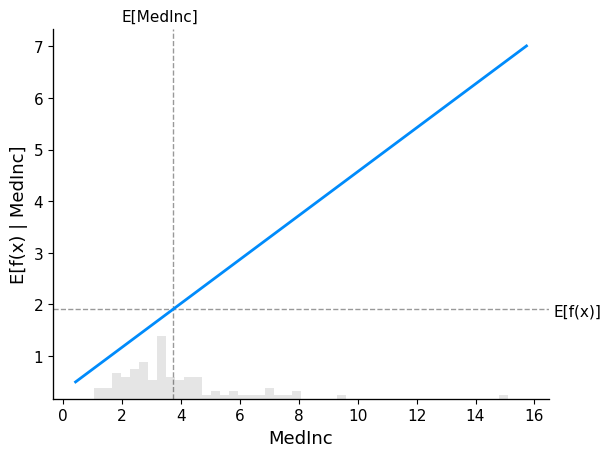

In [9]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### **From PDP to Shap values**

When we are explaining a prediction $f(x)$ the SHAP value for a specific feature $i$ is the difference between the expected model output and the partial dependence plot at the feature's value $x_i$

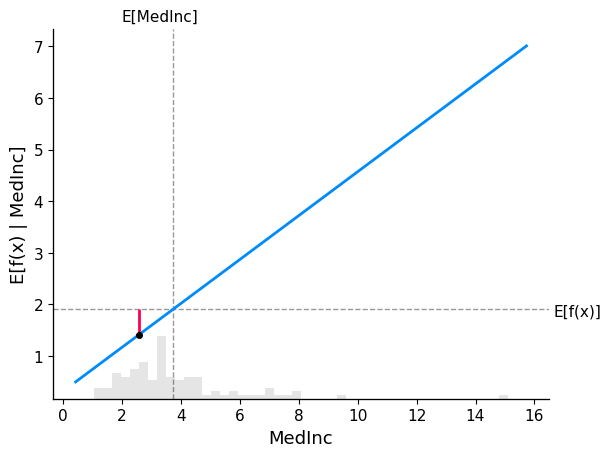

In [10]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

## **Additive nature of Shapley values**
One of the fundamental proprieties of Shap values is that they always sum up to:
$$Outcome (all features) - Outcome (no features)$$

In other terms:

SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained

The easiest way to see this is through a waterfall plot:
1. Start from baseline prediction $E[f(x)]$
2. Adds features until we reach current model output $f(x)$

## **How to read Waterfall plot**

* x-axis has the values of the target (house price)
* x is the chosen observation
* f(x) is the predicted value of the model
* E[f(x)] is the expected value of the target variable (mean of all predictions)

Feature pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

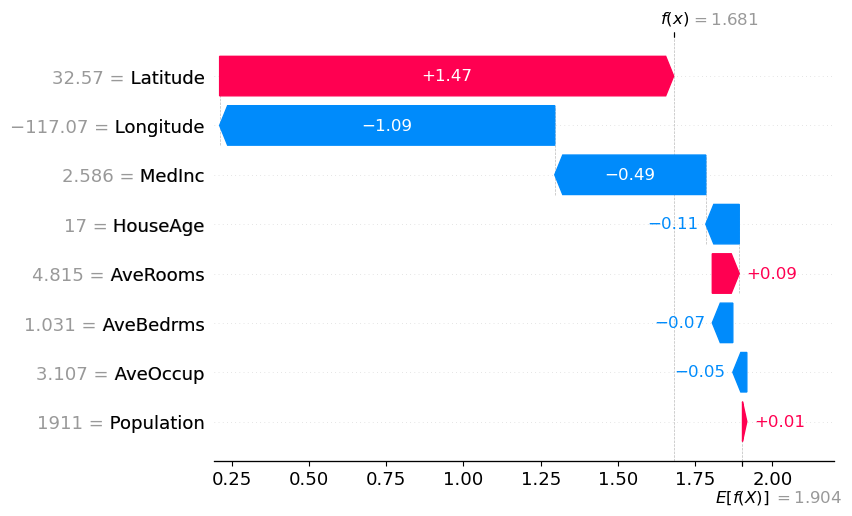

In [11]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [12]:
# Memo Feature name = feature value
shap.plots.force(shap_values[sample_ind])

## **Shap on NON-additivie boosted tree model**

In [13]:
import xgboost

In [14]:
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

In [15]:
explainer_xgb = shap.Explainer(model_xgb, X)
shap_values_xgb = explainer_xgb(X)

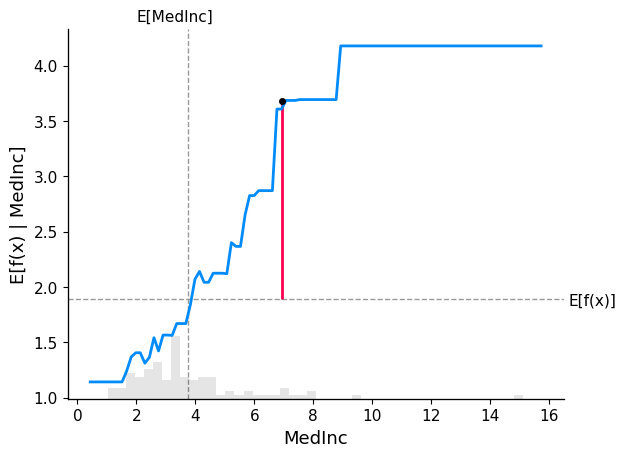

In [16]:
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[800 : 800 + 1, :],
)

## **Explaining a linear logistic regression model**

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
X_adult, y_adult = shap.datasets.adult() #Target (category) : Binary target variable indicating whether the individual earns more than 50K.

In [20]:
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

LogisticRegression(max_iter=10000)

In [21]:
def model_adult_proba(x):
    return model_adult.predict_proba(x)[:, 1]


def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

Explaining the probability of a linear logistic regression model is not linear in the inputs

**NB:**

Logistic regression model is NOT additive in the probability space

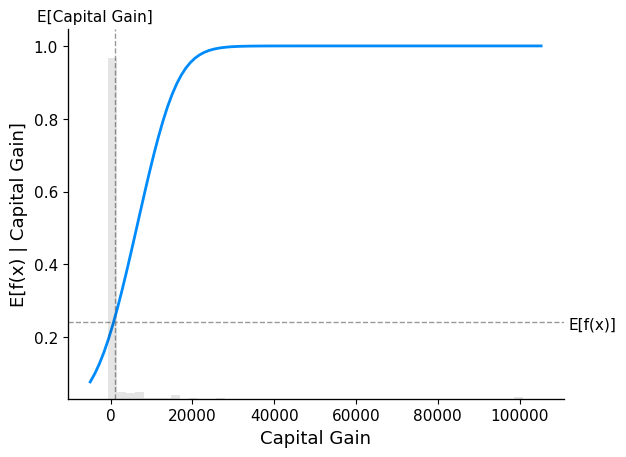

In [22]:
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

If we instead explain the log-odds output of the model we see a perfect linear relationship between the models inputs and the model’s outputs. It is important to remember what the units are of the model you are explaining

PermutationExplainer explainer: 1001it [00:20, 27.48it/s]                          


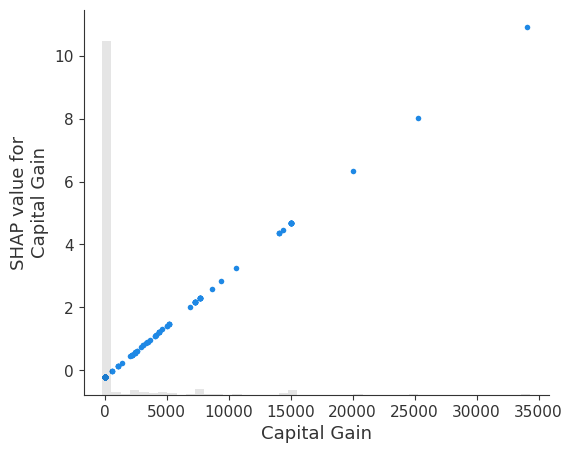

In [23]:
background_adult = shap.maskers.Independent(X_adult, max_samples=100)

explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

shap.plots.scatter(shap_values_adult_log_odds[:, "Capital Gain"])


## **Summarize features importances**

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances

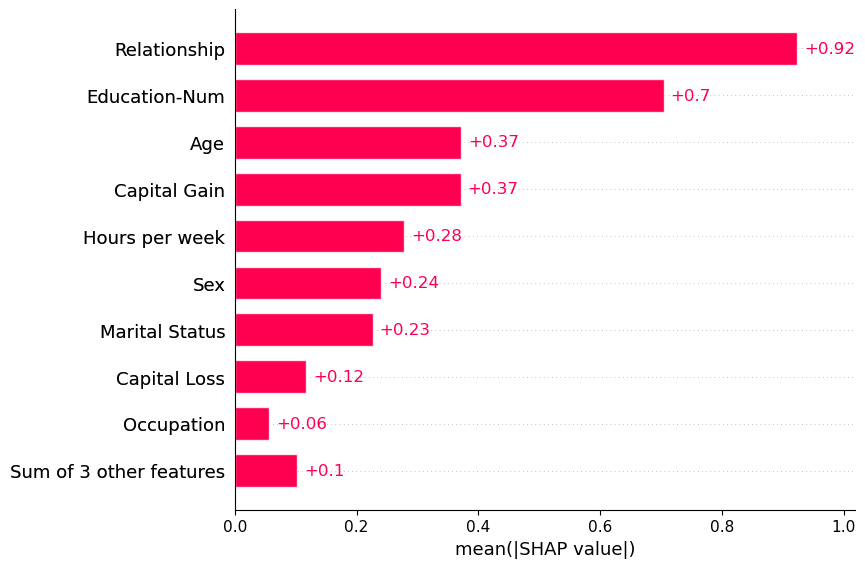

In [24]:
shap.plots.bar(shap_values_adult_log_odds)

We can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrequent but high magnitude effects

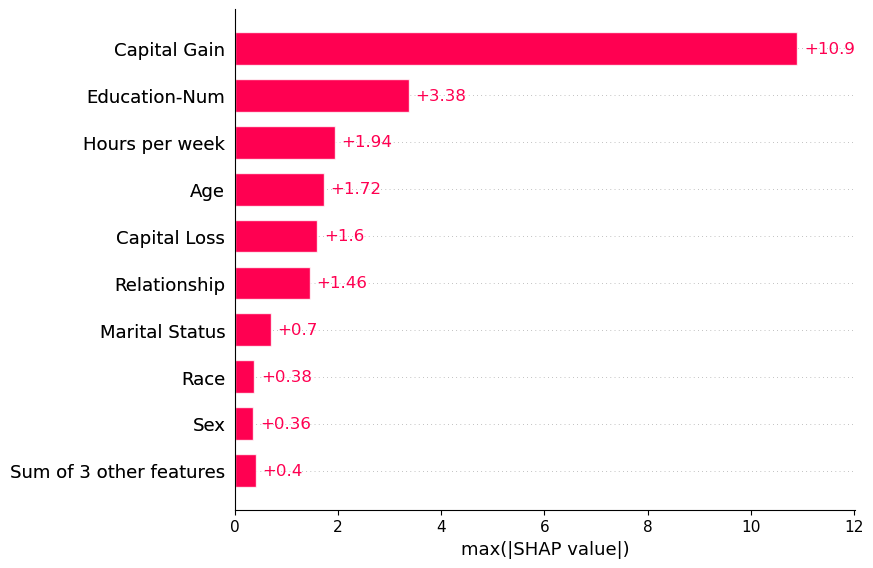

In [25]:
shap.plots.bar(shap_values_adult_log_odds.abs.max(0))

If we are willing to deal with a bit more complexity, we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

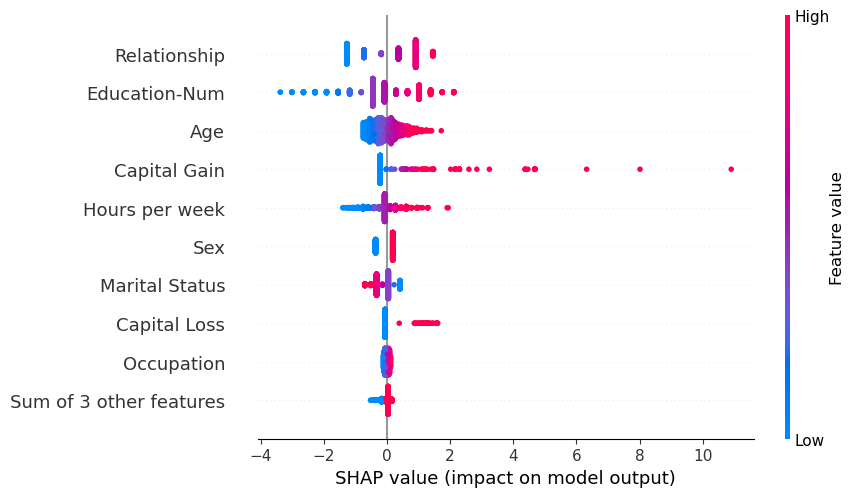

In [26]:
shap.plots.beeswarm(shap_values_adult_log_odds)

Looking for possible interesting clusters. Hight prediction value

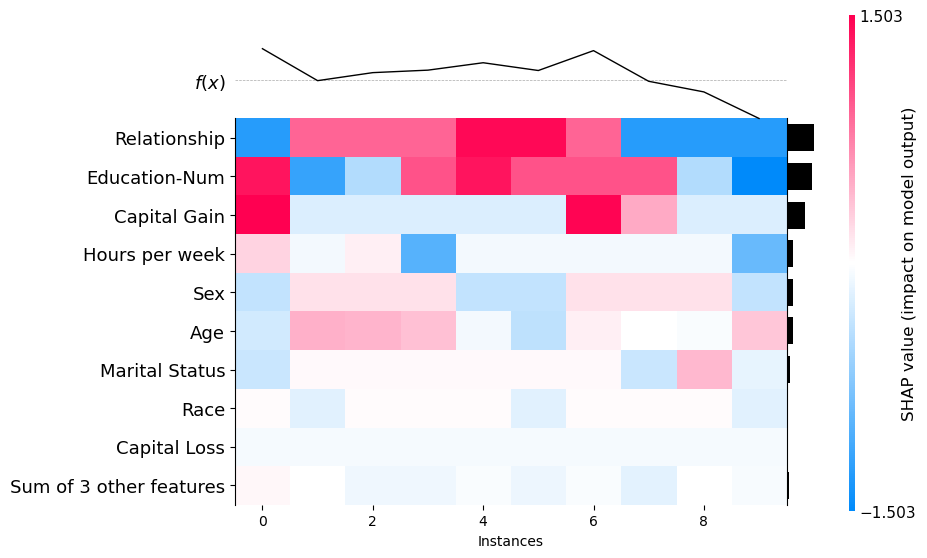

<AxesSubplot: xlabel='Instances'>

In [27]:
shap.plots.heatmap(shap_values_adult_log_odds[:10])
